# Privacy Policies: Decision Tree Classifier

### Imports

In [132]:
import numpy as np
import matplotlib.pyplot as plt
import ssl
import nltk
import os.path
import re
import collections
import pandas as pd
import seaborn as sns
import socket
import pydotplus
import random
import logging

# from six import StringIO

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_graphviz
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from langdetect import detect
from newspaper import Article
from bs4 import BeautifulSoup, NavigableString, Tag
from urllib.request import urlopen, Request
from urllib.error import URLError, HTTPError
from http.client import IncompleteRead
from IPython.display import Image
from pprint import pprint
from time import time

stop_words = stopwords.words('english')

### Methods

Method that converts list to string

In [133]:
def list_to_string(s):
	# initialize an empty string
	str1 = ""
	
	# traverse in the string
	for ele in s:
		str1 += ele
	
	# return string
	return str1

Method to scrape a privacy policy from a given URL

In [134]:
def scrape_policy_url(policy_url):
	parsed_policy = ""
	try:
		article = Article(policy_url)
		article.download()  # Downloads the link’s HTML content
		article.parse()  # Parse the article
		article.nlp()
		# print(policy_url)
		# print(article.text)
		parsed_policy = article
	# except article.ArticleException as ae:
	# print(ae)
	except:
		pass
	# avoid too many requests error from Google
	
	return parsed_policy

Method to find the relevant paragraph of a privacy policy

In [135]:
def find_relevant_paragraph(policy_url):
	# policy_url = "https://irs.gov/privacy-disclosure/report-phishing"
	
	pre_dataframe = [[]]
	potential_paragraph = ""
	headers = {"User-Agent": "Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) "
	                         "Chrome/41.0.2228.0 Safari/537.3"}
	
	# header = {'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; rv:32.0) Gecko/20100101 Firefox/32.0', }
	
	try:
		req = Request(policy_url, headers=headers)
		html = urlopen(req, timeout=1)
		
		# fill first element of the list (first cell of row) with the relevant website title
		# policy_list.append(urlparse(policy.url).netloc + ".txt")
		# html = urlopen('https://automattic.com/privacy/')
		
		bs = BeautifulSoup(html, "html.parser")
		# bs = BeautifulSoup(req.text, "lxml")
		
		# 6 levels of HTML-headers
		# titles = bs.find_all(['h1', 'h2', 'h3', 'h4', 'h5', 'h6'])
		# print('List all the header tags :', *titles, sep='\n\n')
		
		for header in bs.find_all(['h1', 'h2', 'h3', 'h4', 'h5', 'h6']):
			# print(header.text.strip())
			if ("right" or "rights") in header.text.strip().lower():
				
				nextNode = header
				while True:
					nextNode = nextNode.nextSibling
					if nextNode is None:
						break
					if isinstance(nextNode, NavigableString):
						# print(nextNode.strip())
						potential_paragraph = potential_paragraph + " " + nextNode.strip()
					if isinstance(nextNode, Tag):
						if nextNode.name == "h2":
							break
						# print(nextNode.get_text(strip=True).strip())
						potential_paragraph = potential_paragraph + " " + nextNode.get_text(strip=True).strip()
	
	# policy_list.append(header.text.strip())
	# print("*** *** *** END")
	# pre_dataframe.append(policy_list)
	except HTTPError as e:
		# do something
		print('Error code: ', e.code)
		pass
	except URLError as e:
		# do something
		print('Reason: ', e.reason)
		pass
	except socket.timeout as e:
		# if urlopen takes too long just skip the url
		pass
	except IncompleteRead:
		# Oh well, reconnect and keep trucking
		pass
	except ConnectionResetError:
		pass
	except ssl.SSLWantReadError:
		pass
	
	return potential_paragraph

Method to read policy texts from specified directory. The language and length of the policy is held against a check to filter out irrelevant policies

In [136]:
def read_texts(n_words_policy, check_reduced):
	# print("Extracting texts from: " + data_dir)
	all_files = os.listdir(data_dir)
	selected_files = []
	policies_list = []
	titles = []
	
	# filter on txt files (redundant, but safety first)
	txt_files = filter(lambda x: x[-4:] == '.txt', all_files)
	# print("Potential policies found: " + str(len(all_files)))
	
	for file in txt_files:
		# print(file)
		new_file = []
		potential_policy_text = ""
		with open((data_dir + "\\" + file), "r", encoding="utf8") as policy:
			data = policy.readlines()
			policy_text = list_to_string(data[5:])
			policy_url = list_to_string(data[1])[5:]
			new_file[:5] = data[:5]
			if len(policy_text.split()) > n_words_policy:
				lang = detect(policy_text)
				if lang == 'en':
					# print("het is engels")
					# print(lang)
					
					# -if text can be reduced, reduce
					if check_reduced:
						potential_policy_text = find_relevant_paragraph(policy_url)
					
					if len(potential_policy_text) > 20:
						# print("Considering... reduced text")
						policies_list.append(potential_policy_text)
						new_file.append("Reduced Policy: " + potential_policy_text)
					else:
						# print("Considering... full text")
						# otherwise consider text in full
						policies_list.append(policy_text)
					title = (data[0].rstrip("\n").replace("Title: ", ""))
					titles.append(title)
					selected_files.append(file)
				else:
					# print("het is geen engels")
					# print(lang)
					pass
		if len(potential_policy_text) > 20:
			with open((data_dir + "\\" + file), "w", encoding="utf8") as selected_file:
				selected_file.writelines(new_file)
	
	print("Final number of policies after filtering: " + str(len(policies_list)))
	# return policies_list, titles
	return selected_files, policies_list

Method to link the read policies to the URLs of the dataframe 

In [137]:
def select_policies(url_list, policy_list, policy_list_text):
	url_policy_list = []
	counter = 0
	for url in url_list:
		url_counter = 0
		for i, policy in enumerate(policy_list, start=0):  # default is zero
			if url in policy:
				if url_counter == 0:
					url_policy_list.append(policy_list_text[i])
					# print(url)
					# print(policy)
				else:
					# print("Dubbel")
					# if there are multiple policies for one website, select the one that is longer
					if len(policy_list_text[i]) > len(url_policy_list[-1]):
						url_policy_list[-1] = policy_list_text[i]
				url_counter = 1
		if url_counter == 0:
			url_policy_list.append("")
	
	return url_policy_list

Read labelled dataset into a pandas dataframe

In [138]:
def read_data():
	df_pp_read = pd.read_excel(dir)
	
	# SELECT ONLY URLS THAT ARE EITHER RELEVANT OR NOT RELEVANT WITH EXCLUSION CRITERIA CODE E1 (NOT RELEVANT)
	df_pp_relevant = df_pp_read[(df_pp_read['included'] == 'y') | (df_pp_read['included'] == 'e1')]
	
	df_pp_relevant_scoped = df_pp_relevant[
		['URL', 'included', 'UR_explicitly_mentioned', 'access', 'rectification', 'erasure', 'restriction',
		 'data_portability', 'object', 'automated_decision_making']]
	
	df_user_rights = df_pp_relevant[['access', 'rectification', 'erasure', 'restriction',
	                                 'data_portability', 'object', 'automated_decision_making']]
	
	# plot_stats(df_user_rights)
	
	# LIST OF URLs
	url_list = df_pp_relevant_scoped['URL'].tolist()
	
	return df_pp_read, df_pp_relevant, df_pp_relevant_scoped, df_user_rights, url_list

Identify document features (BOG approach)

In [139]:
def document_features2(document):
	document_words = set(document)  # faster than list
	features = {}
	for word in word_features_p:
		features['contains({})'.format(word)] = (word in document_words)
	return features

Preprocess policies

In [140]:
def pre_processing(policies_list):
	counter = 0
	lemma = WordNetLemmatizer()
	# Remove punctuation
	# print("removing punctuation ...")
	policies_list = [re.sub('[,\.!?&“”():*_;"]', '', x) for x in policies_list]
	policies_list = [re.sub('[\'’/]', '', x) for x in policies_list]
	
	# remove digits
	policies_list = [re.sub(r'\d+', '', x) for x in policies_list]
	
	# Convert the titles to lowercase
	policies_list = [x.lower() for x in policies_list]
	
	# remove short words
	policies_list = [' '.join([w for w in x.split() if len(w) > 3]) for x in policies_list]
	
	# tokenizing
	tokenized_policies = [x.split() for x in policies_list]
	
	# lemmatize
	tokenized_policies = [[lemma.lemmatize(y) for y in x] for x in tokenized_policies]
	
	# stemming
	porter = PorterStemmer()
	tokenized_policies = [[porter.stem(y) for y in x] for x in tokenized_policies]
	
	# remove emailadresses and URLs
	# tokenized_policies = [[y for y in x if("@" not in y)] for x in tokenized_policies]
	tokenized_policies = [[y for y in x if (("@" not in y) and ("http" not in y) and
	                                        ("wwww" not in y) and ("com" not in y))] for x in tokenized_policies]
	
	
	# remove stopwords
	tokenized_policies = [[y for y in x if not y in stop_words] for x in tokenized_policies]
	
	# print(relevant_words_lemmatized)
	# print(tokenized_policies)
	# print("length of policy: " + str(len(tokenized_policies)))
	# print("\n")
	
	detokenized_policies = []
	for i in range(len(policies_list)):
		t = ' '.join(tokenized_policies[i])
		detokenized_policies.append(t)
		
	return detokenized_policies

In [141]:
def plot_dataset_dist(category):
    sns.countplot(x = category, data = df_pp, palette = 'hls')
    plt.xlabel('Count', fontsize = 12)
    plt.ylabel('Pre-labeled right to ' + category, fontsize = 13)
    plt.show()

Creating a plot for feature importance,
source: https://www.kaggle.com/josh24990/nlp-ml-which-words-predict-a-recommendation

In [142]:
def importance_plotting(data,x,y,palette,title):
    sns.set(style="whitegrid")
    ft = sns.PairGrid(data,y_vars=y,x_vars=x,size=5,aspect=1)
    ft.map(sns.stripplot,orient='h',palette=palette, edgecolor="black",size=15)
    for ax, title in zip(ft.axes.flat, titles):
        
    # Set a different title for each axes
        ax.set(title=title)
        
    # Make the grid horizontal instead of vertical
        ax.xaxis.grid(False)
        ax.yaxis.grid(True)

    plt.show()


Oversample Automated-Decision Making labeled policies

In [143]:
def oversample_ADM(X_train, y_train):
    y_temp = y_train[(y_train == 1)]
    x_temp = X_train[(y_train == 1)]

# until approx. 50/50 distribution is achieved
    while(int((len(y_train[(y_train == 1)]) / len((y_train)))*100) < 50):

        y_train = y_train.append(y_temp, ignore_index=True)
        X_train = X_train.append(x_temp, ignore_index=True)
#         print("loop")
#         print(int( (len(y_train[(y_train == 1)]) / len((y_train)) )*100))
#         print(len((y_train[(y_train == 1)])) )
#         print( len((y_train)))

    return X_train, y_train

Visualize decision tree

In [154]:
def draw_tree(category, tdidf_dt_classifier, tfidf_vectorizer, suffix):
    # Visualize data
    dot_data = export_graphviz(tdidf_dt_classifier,
                                    feature_names=tfidf_vectorizer.get_feature_names(),
                                    out_file=None,
                                    filled=True,
                                    rounded=True)
    graph = pydotplus.graph_from_dot_data(dot_data)

    colors = ('turquoise', 'orange')
    edges = collections.defaultdict(list)

    for edge in graph.get_edge_list():
        edges[edge.get_source()].append(int(edge.get_destination()))

    for edge in edges:
        edges[edge].sort()    
        for i in range(2):
            dest = graph.get_node(str(edges[edge][i]))[0]
            dest.set_fillcolor(colors[i])

    graph.write_png('output/'+ category + '/' + suffix + '.png')

### Main

Directories

In [145]:
	pd.set_option("display.max_rows", None, "display.max_columns", None)  # print all values of dataframe
	dir = "data/PP_comparison_classification.xlsx"
	data_dir = "data/privacy_policies"

Read the separate datasets and link them

In [146]:
	print("Reading data from: " + dir + " ...")
	df_pp_read, df_pp_relevant, df_pp_relevant_scoped, df_user_rights, url_list = read_data()
	
	# search for corresponding policies
	print("Extracting policy texts from: " + data_dir + " ...")
	policy_list, policy_list_text = read_texts(140, False)
	
	print("Link dataset to extracted policies ... \n")
	url_list_policies = select_policies(url_list, policy_list, policy_list_text)
	url_list_policies = pre_processing(url_list_policies)

Reading data from: data/PP_comparison_classification.xlsx ...
Extracting policy texts from: data/privacy_policies ...
Final number of policies after filtering: 489
Link dataset to extracted policies ... 



Combine datasets in one dataframe

In [147]:
df_pp_relevant_scoped.insert(2, 'policy', url_list_policies)

Print empty policies

In [148]:
#print(df_pp_relevant_scoped[(df_pp_relevant_scoped['policy'] == "")])

#### Policy distribution

In [149]:
categories = ['UR_explicitly_mentioned', 'access', 'rectification', 'erasure', 'restriction',
              'data_portability', 'object', 'automated_decision_making']

# what is the policy distribution?
df_pp_filtered = df_pp_relevant_scoped[(df_pp_relevant_scoped['policy'] != "")]
# print("Policy distribution after filtering out empty policy texts")
# print("* Number of policies included with label \"y\": " + str(len(df_pp_filtered[(df_pp_filtered['included'] == 'y')])))
# print("* Number of policies excluded with label \"e1\": " + str(len(df_pp_filtered[(df_pp_filtered['included'] == 'e1')])))
# print("Total number of policies: " + str(len(df_pp_filtered)) + "\n")

for category in categories:
    print("Category {}".format(category))
    print("Positive labels: {}".format(len(df_pp_filtered[(df_pp_filtered[category] == 1)])))
    print("Negative labels: {} \n".format(len(df_pp_filtered[(df_pp_filtered[category] == 0)])))

df_pp = df_pp_filtered

Category UR_explicitly_mentioned
Positive labels: 87
Negative labels: 46 

Category access
Positive labels: 89
Negative labels: 44 

Category rectification
Positive labels: 87
Negative labels: 46 

Category erasure
Positive labels: 87
Negative labels: 46 

Category restriction
Positive labels: 67
Negative labels: 66 

Category data_portability
Positive labels: 61
Negative labels: 72 

Category object
Positive labels: 67
Negative labels: 66 

Category automated_decision_making
Positive labels: 13
Negative labels: 120 



#### Write processed dataframe to file (attempt to save memory)

In [18]:
df_pp.to_csv('data/processed_policies_v1.csv') #v1 means witthout reduced policies

In [ ]:
#### Read processed dataframe

In [14]:
# data/processed_policies_v1.csv = without reduced policies
# data/processed_policies.csv = with reduced policies
df_pp = pd.read_csv("data/processed_policies_v1.csv")

#### Create dictionary consisting of {policy, label}

In [ ]:
# policy_dict = [(policy_t.split(), label)
# 	             for policy_t in df_pp['policy'].to_list()
# 	             for label in df_pp['data_portability'].to_list()]
	

# # random.shuffle(documents)
# random.shuffle(policy_dict)

#### Explore policy length distribution

In [28]:
# Positive labeled policies PROBLEEM MET DE VALUES
len(df_pp[df_pp['data_portability'] == 1])

61

In [29]:
# Negative labeled policies
# len(df_pp[df_pp['object'] == 0])

# df['Review'].values.astype('U')
print(df_pp['data_portability'].values)
# print(len(df_pp['object']))
# print(len(df_pp[df_pp['object'] == 1]))
# print(len(df_pp[df_pp['object'] == 0]))
# print((df_pp[df_pp['object'] == 0]))

# print(df_pp['object'].isnull().values.any())

# print(df_pp[df_pp['object'].isnull()])

[1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.
 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1.
 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1.
 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0.
 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0.
 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1.]


0       3510
2       8059
3      20308
5        796
6      40684
7      20891
14      3777
15     84415
16      8769
17     15405
18      2686
21     19052
25     49213
26      2933
32     19199
33     13675
34     22348
36     11909
37      3661
40     26769
42      9594
43     15404
44     23759
45      7778
46      3883
48      1717
50     17050
51     18296
52      3229
53     14218
55     15065
57     19084
58     18521
59     21552
62      2763
63     11564
64     13651
66      2208
67      9472
69     15780
73     18018
76      9633
77     28294
78     16805
79     10599
80     36935
83     14653
84      1213
86     24077
87      1026
88     13204
91      1010
92      5161
93     18489
94     21052
96     17290
97      8145
98       403
101     6274
104    23913
105    23913
110    36734
114    19348
125     2425
126    14047
128      403
129     6274
132    23913
133    23913
135    36734
137    19348
139     2425
140    14047
Name: policy, dtype: int64


c:\users\aaberkan\onedrive - ugent\scripts\nlp4re-privacy-policies\nlp4re-pp-classification\venv\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\aaberkan\onedrive - ugent\scripts\nlp4re-privacy-policies\nlp4re-pp-classification\venv\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


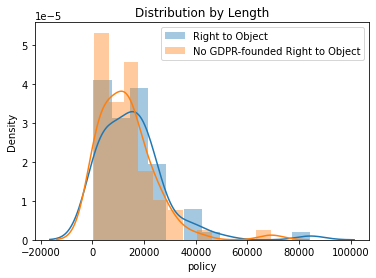

In [15]:
RTobject =df_pp[df_pp['object'] == 1]['policy'].str.len()
print(df_pp[df_pp['object'] == 1]['policy'].str.len())
sns.distplot(RTobject, label='Right to Object')
NRTobject = df_pp[df_pp['object'] == 0]['policy'].str.len()
sns.distplot(NRTobject, label='No GDPR-founded Right to Object')
plt.title('Distribution by Length')
plt.legend()

##### Divide data into training and testset

In [37]:
# size_p = int(len(featuresets_p) * 0.5)
# train_set_p, test_set_p = featuresets_p[size_p:], featuresets_p[:size_p]
X_train, X_test, y_train, y_test = train_test_split(df_pp['policy'], df_pp['automated_decision_making'], test_size=0.33, random_state=0)


#### Train classifier and classify

In [ ]:
# classifier = nltk.DecisionTreeClassifier.train(train_set_p)
# print(nltk.classify.accuracy(classifier, test_set_p))
# print(classifier.pseudocode(depth=4))

In [ ]:
# accuracy = nltk.classify.accuracy(nltk_model, test_set_p)*100
# print("{} Accuracy: {}".format("Decision Tree", accuracy))

## Countvectorizer Approach

##### Search for best variables (countvectorizer)

In [79]:
tfidf_pipeline = Pipeline([
    ('cv', CountVectorizer()),
    ('dt', DecisionTreeClassifier()),
])

# increase processing time in a combinatorial way
parameters = {
#     'cv__min_df': (0.25, 0.5, 1), #best solution: 1
    'cv__max_df': (0.5, 0.75, 1), #best solution: .5
#     'tfidf__max_df': (0.5, 0.75, 1.0),
#     'cv__max_features': (None, 5000, 10000, 50000),
    'cv__ngram_range': ((1, 1), (1, 2), (1, 3), (2, 2), (2, 3), (3, 3)) #best solution: 1,1
}
        
grid_search = GridSearchCV(tfidf_pipeline, parameters)

print("Performing grid search...")
print("tf-idf pipeline:", [name for name, _ in tfidf_pipeline.steps])
print("parameters:")
pprint(parameters)
t0 = time()
grid_search.fit(X_train, y_train) 
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
tf-idf pipeline: ['cv', 'dt']
parameters:
{'cv__max_df': (0.5, 0.75, 1),
 'cv__ngram_range': ((1, 1), (1, 2), (1, 3), (2, 2), (2, 3), (3, 3))}


KeyboardInterrupt: 

#### Countvectorizer

In [20]:
# Instantiate the vectorizer
count_vectorizer = CountVectorizer(ngram_range=(1, 1), max_df=1, min_df=1)

# fit and transform on it the training features
count_vectorizer.fit(X_train)
X_train_word_features = count_vectorizer.transform(X_train)

#transform the test features to sparse matrix
test_features = count_vectorizer.transform(X_test)

classifier = DecisionTreeClassifier(criterion="gini")

classifier.fit(X_train_word_features, y_train)
y_pred = classifier.predict(test_features)
y_pred_prob = classifier.predict_proba(test_features)[:, 1]
# print(y_pred_prob)

print('CV Accuracy: {}'.format(accuracy_score(y_test, y_pred)))
print("CV ROC_AUC Score: {}\n".format(roc_auc_score(y_test, y_pred_prob)))

print(classification_report(y_test, y_pred))

print(classification_report(y_test, y_pred))
# print(confusion_matrix(y_test, y_pred))
print(pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    index = [['actual', 'actual'], ['Object', 'not-Object']],
    columns = [['predicted', 'predicted'], ['Object', 'not-Object']])) 

CV Accuracy: 0.6136363636363636
CV ROC_AUC Score: 0.5929752066115703

              precision    recall  f1-score   support

         0.0       0.86      0.27      0.41        22
         1.0       0.57      0.95      0.71        22

    accuracy                           0.61        44
   macro avg       0.71      0.61      0.56        44
weighted avg       0.71      0.61      0.56        44

              precision    recall  f1-score   support

         0.0       0.86      0.27      0.41        22
         1.0       0.57      0.95      0.71        22

    accuracy                           0.61        44
   macro avg       0.71      0.61      0.56        44
weighted avg       0.71      0.61      0.56        44

                  predicted           
                     Object not-Object
actual Object             6         16
       not-Object         1         21


#### Visualize Countvector Decision-Tree Classification Results

In [ ]:
# Visualize data
dot_data = export_graphviz(classifier,
                                feature_names=count_vectorizer.get_feature_names(),
                                out_file=None,
                                filled=True,
                                rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)

colors = ('turquoise', 'orange')
edges = collections.defaultdict(list)

for edge in graph.get_edge_list():
    edges[edge.get_source()].append(int(edge.get_destination()))

for edge in edges:
    edges[edge].sort()    
    for i in range(2):
        dest = graph.get_node(str(edges[edge][i]))[0]
        dest.set_fillcolor(colors[i])

graph.write_png('output/cv-tree.png')

## TD-IDF Approach

##### Search for best variables (tf-idf)

In [16]:
# 'UR_explicitly_mentioned' weggelaten
categories = ['access', 'rectification', 'erasure', 'restriction',
              'data_portability', 'object', 'automated_decision_making']

for i, category in enumerate(categories):
    tfidf_pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('dt', DecisionTreeClassifier()),
    ])

    # increase processing time in a combinatorial way
    parameters = {
    #     'tfidf__min_df': (0.5, 0.75, 1.0), #best solution: (.75)
        'tfidf__max_df': (0.75, 1.0), #best solution: (1.)
    #     'tfidf__max_features': (None, 5000, 10000, 50000),
        'tfidf__ngram_range': ((1, 1), (1, 2), (1, 3), (2, 2), (2, 3), (3, 3)), #best solution: (1,2)
        'dt__max_depth': np.arange(3,10)
    }

    #https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680
    X_train, X_test, y_train, y_test = train_test_split(df_pp['policy'], df_pp[category], test_size=0.33, random_state=0)
    grid_search = GridSearchCV(tfidf_pipeline, parameters)

    print("Performing grid search for label: {}".format(category))
    print("tf-idf pipeline:", [name for name, _ in tfidf_pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(X_train, y_train) 
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search for access
tf-idf pipeline: ['tfidf', 'dt']
parameters:
{'dt__max_depth': array([3, 4, 5, 6, 7, 8, 9]),
 'tfidf__max_df': (0.75, 1.0),
 'tfidf__ngram_range': ((1, 1), (1, 2), (1, 3), (2, 2), (2, 3), (3, 3))}
done in 231.400s

Best score: 0.743
Best parameters set:
	dt__max_depth: 9
	tfidf__max_df: 1.0
	tfidf__ngram_range: (1, 1)
Performing grid search for rectification
tf-idf pipeline: ['tfidf', 'dt']
parameters:
{'dt__max_depth': array([3, 4, 5, 6, 7, 8, 9]),
 'tfidf__max_df': (0.75, 1.0),
 'tfidf__ngram_range': ((1, 1), (1, 2), (1, 3), (2, 2), (2, 3), (3, 3))}
done in 253.200s

Best score: 0.696
Best parameters set:
	dt__max_depth: 3
	tfidf__max_df: 0.75
	tfidf__ngram_range: (1, 1)
Performing grid search for erasure
tf-idf pipeline: ['tfidf', 'dt']
parameters:
{'dt__max_depth': array([3, 4, 5, 6, 7, 8, 9]),
 'tfidf__max_df': (0.75, 1.0),
 'tfidf__ngram_range': ((1, 1), (1, 2), (1, 3), (2, 2), (2, 3), (3, 3))}
done in 244.225s

Best score: 0.731
Best parameters 

#### TF-IDF Vectorizer

In [34]:
# Instantiate the vectorizer
# tfidf_vectorizer = TfidfVectorizer(max_df=.75, ngram_range=(2, 3))
X_train, X_test, y_train, y_test = train_test_split(df_pp['policy'], df_pp['erasure'], test_size=0.33, random_state=0)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(3,3))

# fit and transform on it the training features
tfidf_vectorizer.fit(X_train)
X_train_word_features = tfidf_vectorizer.transform(X_train)

#transform the test features to sparse matrix
test_features = tfidf_vectorizer.transform(X_test)

# https://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use max_depth = 3
tdidf_dt_classifier = DecisionTreeClassifier(criterion="gini", max_depth = 3)

tdidf_dt_classifier.fit(X_train_word_features, y_train)
y_pred = tdidf_dt_classifier.predict(test_features)
y_pred_prob = tdidf_dt_classifier.predict_proba(test_features)[:, 1]

print('CV Accuracy: {}'.format(accuracy_score(y_test, y_pred)))
print("CV ROC_AUC Score: {}\n".format(roc_auc_score(y_test, y_pred_prob)))

print(classification_report(y_test, y_pred))

print(classification_report(y_test, y_pred))
# print(confusion_matrix(y_test, y_pred))
print(pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    index = [['actual', 'actual'], ['Object', 'not-Object']],
    columns = [['predicted', 'predicted'], ['Object', 'not-Object']])) 


CV Accuracy: 0.6818181818181818
CV ROC_AUC Score: 0.6987179487179488

              precision    recall  f1-score   support

         0.0       0.60      0.67      0.63        18
         1.0       0.75      0.69      0.72        26

    accuracy                           0.68        44
   macro avg       0.68      0.68      0.68        44
weighted avg       0.69      0.68      0.68        44

              precision    recall  f1-score   support

         0.0       0.60      0.67      0.63        18
         1.0       0.75      0.69      0.72        26

    accuracy                           0.68        44
   macro avg       0.68      0.68      0.68        44
weighted avg       0.69      0.68      0.68        44

                  predicted           
                     Object not-Object
actual Object            12          6
       not-Object         8         18


#### Plot feature importance

c:\users\aaberkan\onedrive - ugent\scripts\nlp4re-privacy-policies\nlp4re-pp-classification\venv\lib\site-packages\seaborn\axisgrid.py:1150: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


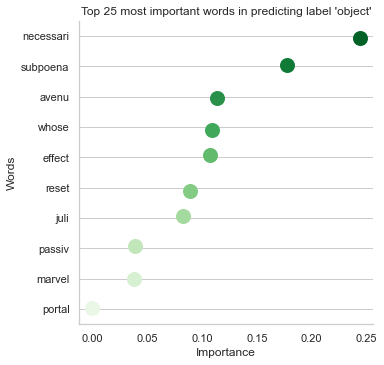

In [22]:
# Find out the most important features from the tfidf classification model
# top_features = [(number, feature, tfidf_vectorizer.get_feature_names()[number]) for number, feature in 
#                 zip(range(len(tdidf_dt_classifier.feature_importances_)), tdidf_dt_classifier.feature_importances_) if feature > 0.0005]
# print(top_features)

fi = {'Words':tfidf_vectorizer.get_feature_names(),'Importance':tdidf_dt_classifier.feature_importances_}
Importance = pd.DataFrame(fi,index=None).sort_values('Importance',ascending=False).head(10)
titles = ["Top 25 most important words in predicting label \'object\'"]

importance_plotting(Importance,'Importance','Words','Greens_r',titles)

#### Visualize TD-IDF Decision-Tree Classification Results

In [23]:
# Visualize data
dot_data = export_graphviz(tdidf_dt_classifier,
                                feature_names=tfidf_vectorizer.get_feature_names(),
                                out_file=None,
                                filled=True,
                                rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)

colors = ('turquoise', 'orange')
edges = collections.defaultdict(list)

for edge in graph.get_edge_list():
    edges[edge.get_source()].append(int(edge.get_destination()))

for edge in edges:
    edges[edge].sort()    
    for i in range(2):
        dest = graph.get_node(str(edges[edge][i]))[0]
        dest.set_fillcolor(colors[i])

graph.write_png('output/tfidf-tree.png')

True

#### TF-IDF Decision-Tree Classification and visualization of all labels

Classifying privacy policies, label: access
66% of the policies is pre-labeled as positive 
[5, (1, 1)]
TFIDF Accuracy: 0.675
TFIDF ROC_AUC Score: 0.6794871794871794

              precision    recall  f1-score   support

         0.0       0.50      0.69      0.58        13
         1.0       0.82      0.67      0.73        27

    accuracy                           0.68        40
   macro avg       0.66      0.68      0.66        40
weighted avg       0.71      0.68      0.68        40

                  predicted           
                     access not-access
actual access             9          4
       not-access         9         18


c:\users\aaberkan\onedrive - ugent\scripts\nlp4re-privacy-policies\nlp4re-pp-classification\venv\lib\site-packages\seaborn\axisgrid.py:1150: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


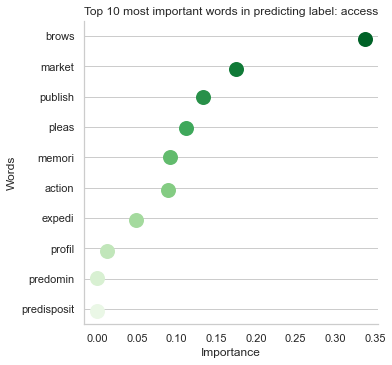

Draw tree ..
Completed!
*********************** 

Classifying privacy policies, label: rectification
65% of the policies is pre-labeled as positive 
[5, (2, 2)]
TFIDF Accuracy: 0.725
TFIDF ROC_AUC Score: 0.7586666666666666

              precision    recall  f1-score   support

         0.0       0.67      0.53      0.59        15
         1.0       0.75      0.84      0.79        25

    accuracy                           0.73        40
   macro avg       0.71      0.69      0.69        40
weighted avg       0.72      0.72      0.72        40

                             predicted                  
                         rectification not-rectification
actual rectification                 8                 7
       not-rectification             4                21


c:\users\aaberkan\onedrive - ugent\scripts\nlp4re-privacy-policies\nlp4re-pp-classification\venv\lib\site-packages\seaborn\axisgrid.py:1150: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


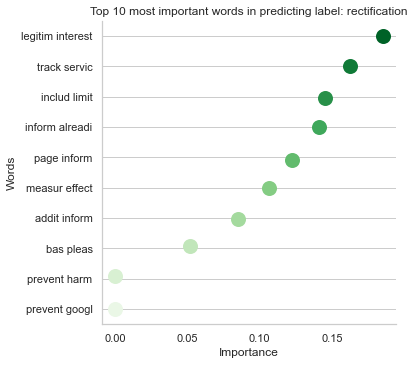

Draw tree ..
Completed!
*********************** 

Classifying privacy policies, label: erasure
65% of the policies is pre-labeled as positive 
[3, (3, 3)]
TFIDF Accuracy: 0.675
TFIDF ROC_AUC Score: 0.6923076923076923

              precision    recall  f1-score   support

         0.0       0.53      0.64      0.58        14
         1.0       0.78      0.69      0.73        26

    accuracy                           0.68        40
   macro avg       0.66      0.67      0.66        40
weighted avg       0.69      0.68      0.68        40

                   predicted            
                     erasure not-erasure
actual erasure             9           5
       not-erasure         8          18


c:\users\aaberkan\onedrive - ugent\scripts\nlp4re-privacy-policies\nlp4re-pp-classification\venv\lib\site-packages\seaborn\axisgrid.py:1150: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


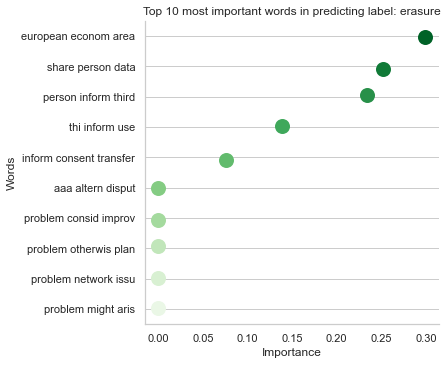

Draw tree ..
Completed!
*********************** 

Classifying privacy policies, label: restriction
50% of the policies is pre-labeled as positive 
[3, (2, 2)]
TFIDF Accuracy: 0.65
TFIDF ROC_AUC Score: 0.6892583120204603

              precision    recall  f1-score   support

         0.0       0.55      0.94      0.70        17
         1.0       0.91      0.43      0.59        23

    accuracy                           0.65        40
   macro avg       0.73      0.69      0.64        40
weighted avg       0.76      0.65      0.63        40

                         predicted                
                       restriction not-restriction
actual restriction              16               1
       not-restriction          13              10


c:\users\aaberkan\onedrive - ugent\scripts\nlp4re-privacy-policies\nlp4re-pp-classification\venv\lib\site-packages\seaborn\axisgrid.py:1150: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


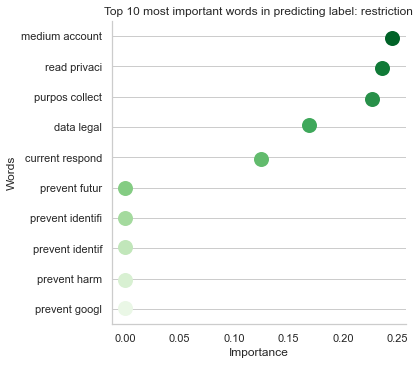

Draw tree ..
Completed!
*********************** 

Classifying privacy policies, label: data_portability
45% of the policies is pre-labeled as positive 
[4, (3, 3)]
TFIDF Accuracy: 0.675
TFIDF ROC_AUC Score: 0.6713554987212276

              precision    recall  f1-score   support

         0.0       0.73      0.70      0.71        23
         1.0       0.61      0.65      0.63        17

    accuracy                           0.68        40
   macro avg       0.67      0.67      0.67        40
weighted avg       0.68      0.68      0.68        40

                                   predicted                     
                            data_portability not-data_portability
actual data_portability                   16                    7
       not-data_portability                6                   11


c:\users\aaberkan\onedrive - ugent\scripts\nlp4re-privacy-policies\nlp4re-pp-classification\venv\lib\site-packages\seaborn\axisgrid.py:1150: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


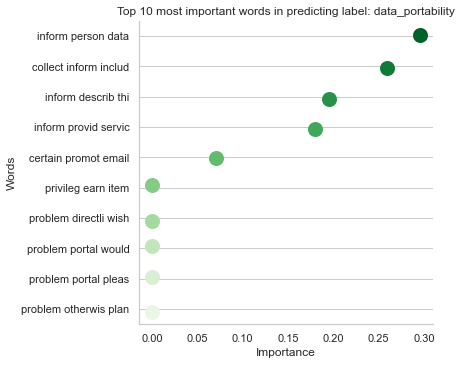

Draw tree ..
Completed!
*********************** 

Classifying privacy policies, label: object
50% of the policies is pre-labeled as positive 
[3, (3, 3)]
TFIDF Accuracy: 0.625
TFIDF ROC_AUC Score: 0.678030303030303

              precision    recall  f1-score   support

         0.0       0.58      0.61      0.59        18
         1.0       0.67      0.64      0.65        22

    accuracy                           0.62        40
   macro avg       0.62      0.62      0.62        40
weighted avg       0.63      0.62      0.63        40

                  predicted           
                     object not-object
actual object            11          7
       not-object         8         14


c:\users\aaberkan\onedrive - ugent\scripts\nlp4re-privacy-policies\nlp4re-pp-classification\venv\lib\site-packages\seaborn\axisgrid.py:1150: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


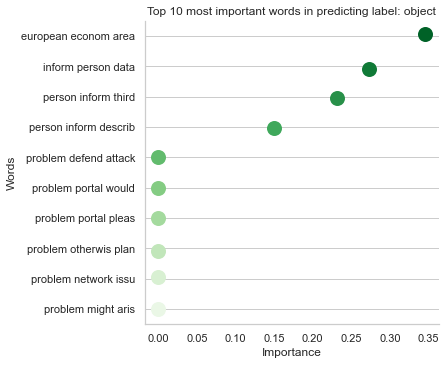

Draw tree ..
Completed!
*********************** 

Classifying privacy policies, label: automated_decision_making
9% of the policies is pre-labeled as positive 
[3, (2, 2)]
Oversampling training set...
50% of the training set policies is pre-labeled as positive.
TFIDF Accuracy: 0.775
TFIDF ROC_AUC Score: 0.44285714285714284

              precision    recall  f1-score   support

         0.0       0.86      0.89      0.87        35
         1.0       0.00      0.00      0.00         5

    accuracy                           0.78        40
   macro avg       0.43      0.44      0.44        40
weighted avg       0.75      0.78      0.76        40

                                                     predicted  \
                                     automated_decision_making   
actual automated_decision_making                            31   
       not-automated_decision_making                         5   

                                                                    
             

c:\users\aaberkan\onedrive - ugent\scripts\nlp4re-privacy-policies\nlp4re-pp-classification\venv\lib\site-packages\seaborn\axisgrid.py:1150: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


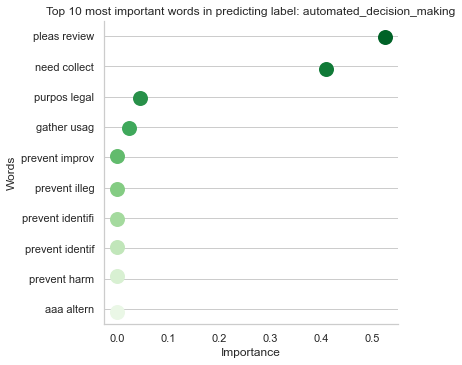

Draw tree ..
Completed!
*********************** 



In [155]:
# 'UR_explicitly_mentioned' weggelaten
categories = ['access', 'rectification', 'erasure', 'restriction',
              'data_portability', 'object', 'automated_decision_making']

params = [
    [5,(1,1)],
    [5,(2,2)],
    [3,(3,3)],
    [3,(2,2)],
    [4,(3,3)],
    [3,(3,3)],
    [3,(2,2)],
]

# categories = ['automated_decision_making']


for i, category in enumerate(categories):
   
    print("Classifying privacy policies, label: {}".format(category))
    print("{}% of the policies is pre-labeled as positive ".format(int((len(df_pp[df_pp[category] == 1])/len(df_pp[category]))*100)))
    X_train, X_test, y_train, y_test = train_test_split(df_pp['policy'], df_pp[category], test_size=0.3, random_state=0)
    print(params[i])

#     generaliseren dmv int((len(df_pp[df_pp[category] == 1])/len(df_pp[category]))*100)) < 30
    if(category == "automated_decision_making"):
        print("Oversampling training set...")
#         print(len(y_train))
        X_train, y_train = oversample_ADM(X_train, y_train)
        print("{}% of the training set policies is pre-labeled as positive.".format(int((len(y_train[(y_train == 1)]) / len((y_train)))*100)))
#         print(len(y_train))

#     plot_dataset_dist(category)
    
    # Instantiate the vectorizer
    tfidf_vectorizer = TfidfVectorizer(ngram_range=params[i][1])

    # fit and transform on it the training features
    tfidf_vectorizer.fit(X_train)
    X_train_word_features = tfidf_vectorizer.transform(X_train)

    #transform the test features to sparse matrix
    test_features = tfidf_vectorizer.transform(X_test)

    classifier = DecisionTreeClassifier(criterion="gini", max_depth = params[i][0])

    classifier.fit(X_train_word_features, y_train)
    y_pred = classifier.predict(test_features)
    y_pred_prob = classifier.predict_proba(test_features)[:, 1]
#     print(y_pred)
#     print(y_test)

#     print(y_pred)
    print('TFIDF Accuracy: {}'.format(accuracy_score(y_test, y_pred)))
    print("TFIDF ROC_AUC Score: {}\n".format(roc_auc_score(y_test, y_pred_prob)))

    print(classification_report(y_test, y_pred))
    # print(confusion_matrix(y_test, y_pred))
    print(pd.DataFrame(
        confusion_matrix(y_test, y_pred),
        index = [['actual', 'actual'], [category, 'not-'+category]],
        columns = [['predicted', 'predicted'], [category, 'not-'+category]])) 
    
    # plot word importance
    fi = {'Words':tfidf_vectorizer.get_feature_names(),'Importance':classifier.feature_importances_}
    Importance = pd.DataFrame(fi,index=None).sort_values('Importance',ascending=False).head(10)
    titles = ["Top 10 most important words in predicting label: " + category]
    importance_plotting(Importance,'Importance','Words','Greens_r',titles)
    
    print("Draw tree ..")
    draw_tree(category, classifier, tfidf_vectorizer, category + " - TL3 - stopwords + stemming + lemmatization")
    print("Completed!")
    print("*********************** \n")